In [466]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
%load_ext autoreload
%autoreload 2

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"
dataset_name = "V1_Adult_Mouse_Brain"
dataset_folder = os.path.join(
    BASE_PATH, "20191205_10XVisium_MouseBrainCoronal_giovanni.palla"
)
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [467]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [512]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import _count_observations_by_pairs
from spatial_tools.graph.nhood import *

### Small test (edges, nodes, nodes-fast)

In [513]:
positions = np.arange(5)
leiden = np.array([1, 1, 2, 2, 2])
conn = np.array([[0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0]])

print('connectivities')
print(conn)
print('leiden', leiden)
print('positions', positions)

connectivities
[[0 0 1 1 1]
 [0 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]
leiden [1 1 2 2 2]
positions [0 1 2 3 4]


In [514]:
edges = _count_observations_by_pairs(conn, leiden, positions, count_option='edges')
edges.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,6,edges,1:2


In [515]:
nodes = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')
nodes.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


In [516]:
nodes_dev = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes-dev')
nodes_dev.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


When using nodes the output is as expected. The implementation based on nodes-fast returns the minimum number apparently
- This could be a minor modification somewhere
- Additionally np.meshgrid([x, y]) can be implemented for option='nodes', to avoid writing the function cartesian
    - A more detailed discussion in here
https://stackoverflow.com/questions/1208118/using-numpy-to-build-an-array-of-all-combinations-of-two-arrays

In [517]:
positions = np.arange(5)
leiden = np.array([1, 1, 2, 2, 2])
conn = np.array([[0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0]])

print('connectivities')
print(conn)
print('leiden', leiden)
print('positions', positions)

connectivities
[[0 0 1 1 1]
 [0 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]]
leiden [1 1 2 2 2]
positions [0 1 2 3 4]


In [518]:
edges = _count_observations_by_pairs(conn, leiden, positions, count_option='edges')
edges.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,6,edges,1:2


### Issue: here the nodes-dev should throw 5 but instead it throws 3. Probably it counts only one category (tbc)

In [519]:
nodes_fast = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes-dev')
nodes_fast.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


In [520]:
nodes = _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')
nodes.head()

,leiden.i,leiden.j,n.obs,mode,k
0,1,2,5,nodes,1:2


## Big test (10x visium data)

In [703]:
from spatial_tools.graph.build import spatial_connectivity
from spatial_tools.graph.nhood import _count_observations_by_pairs
from spatial_tools.graph.nhood import *

In [527]:
spatial_connectivity(adata, n_degree=3)
conn = adata.obsp['spatial_connectivity']

leiden = adata.obs['leiden']
N = adata.shape[0]
positions = np.arange(N) # .reshape(w, h)

In [704]:
n_permutations = 100

This is for profiling the speed of functions and speeding up. Uncomment for checking

In [484]:
# %load_ext line_profiler

# %lprun -f permutation_test_leiden_pairs permutation_test_leiden_pairs(adata, n_permutations=10, count_option='edges')
# %lprun -f permutation_test_leiden_pairs permutation_test_leiden_pairs(adata, n_permutations=100, print_log_each=25)
# %lprun -f _count_observations_by_pairs _count_observations_by_pairs(conn, leiden, positions, count_option='nodes')

In [679]:
len(list(combinations(set(leiden), r=2)))

171

In [669]:
%time permutation_test_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='edges')
edges = adata.uns['nhood_permutation_test'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
25 out of 100 permutations
50 out of 100 permutations
75 out of 100 permutations
100 out of 100 permutations
CPU times: user 14.6 s, sys: 21.2 ms, total: 14.6 s
Wall time: 14.7 s


In [670]:
edges.shape
edges[(edges['k'] == '3:9') | (edges['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
56,3,9,19,edges,3:9,220,147,-9.933635,159.45,14.138832


In [705]:
%time permutation_test_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes')
nodes = adata.uns['nhood_permutation_test'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
25 out of 100 permutations
50 out of 100 permutations
75 out of 100 permutations
100 out of 100 permutations
(171, 10)
(342, 11)
CPU times: user 15.3 s, sys: 3.47 s, total: 18.7 s
Wall time: 18.8 s


In [702]:
nodes.shape
nodes[(nodes['k'] == '3:9') | (nodes['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,k.sorted
59,9,3,355,nodes,9:3,147,220,-2.691256,360.2,1.932184,3:9
59,3,9,355,nodes,3:9,147,220,-2.691256,360.2,1.932184,3:9


In [673]:
%time permutation_test_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes-dev')
nodes_dev = adata.uns['nhood_permutation_test'].copy()

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
25 out of 100 permutations
50 out of 100 permutations
75 out of 100 permutations
100 out of 100 permutations
CPU times: user 15 s, sys: 6.43 ms, total: 15 s
Wall time: 15.1 s


In [674]:
nodes_dev.shape
nodes_dev[(nodes_dev['k'] == '3:9') | (nodes_dev['k'] == '9:3')]

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
56,3,9,27,nodes-dev,3:9,220,147,-9.684815,99.52,7.488011


### Here we check whether the association between nodes and nodes-dev makes sense

Text(0, 0.5, '# obs (nodes-dev)')

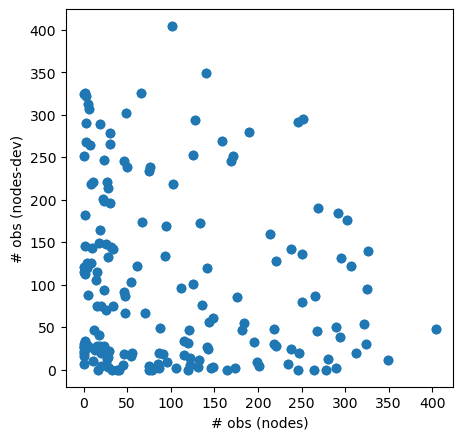

In [543]:
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [5, 5]
x = nodes.set_index('k')['n.obs'].to_dict()
y = nodes_dev.set_index('k')['n.obs'].to_dict()
v = pd.DataFrame(index=x.keys())
v['nodes'] = v.index.map(x)
v['nodes.dev'] = v.index.map(y)
plt.scatter(v['nodes'], v['nodes.dev'])
plt.xlabel('# obs (nodes)')
plt.ylabel('# obs (nodes-dev)')

Currently the running time is ~15-20s / 100 permutations. Therefore
- 1000 permutations would take ~150-200 s. 
- 10k permutations would take ~1500-2000 s.

In [709]:
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.dpi'] = 100
rcParams['figure.figsize'] = [10, 15]

In [ ]:
pi = 0
for df, lab in zip([edges, nodes, nodes_dev], ['edges', 'nodes', 'nodes-dev']):
    hm = df.pivot('leiden.i', 'leiden.j', 'z.score')
    annot = df.pivot('leiden.i', 'leiden.j', 'n.obs')

    plt.subplot2grid([3, 4], [pi, 0], rowspan=1, colspan=1)
    plt.hist(np.array(hm).flatten(), bins=100);
    plt.xlabel('z-score')
    plt.ylabel('density')

    vmax = max(hm.max())
    vmin = -5 # vmax
    # print(vmin, vmax)
    idx = hm.index.astype(int).sort_values().astype(int)
    # print(idx)

    plt.subplot2grid([3, 4], [pi, 1], rowspan=1, colspan=3)
    sns.heatmap(hm.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose(),
                annot=annot.reindex([i for i in idx if i in hm.index])[[i for i in idx if i in hm]].transpose(),
                fmt='.0f',
                cmap='Reds', vmin=0, vmax=vmax,
                cbar_kws={'label': 'Z-score'},
                annot_kws={'fontsize': 5}, xticklabels=True, yticklabels=True)
    plt.title('Co-enrichment of pairs in connectivity graph (%s)' % (lab))
    plt.tight_layout()
    pi += 1

### Check based on nodes clusters that seemed of interest

In [555]:
settest = {'9', '3'}

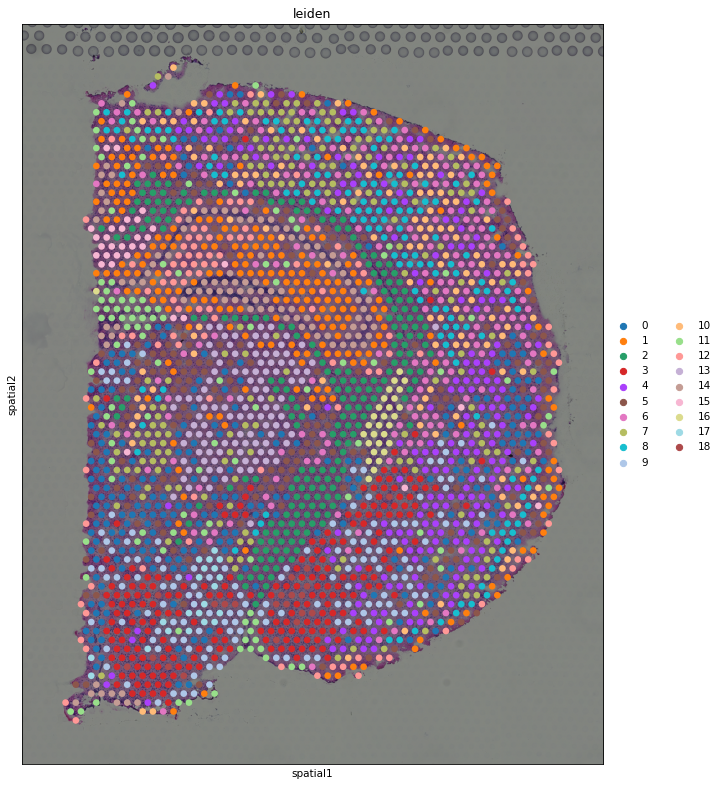

In [556]:
rcParams['figure.dpi'] = 75
sc.pl.spatial(adata, color = "leiden")

In [566]:
%time permutation_test_leiden_pairs(adata, n_permutations=n_permutations, count_option='nodes')
nodes = adata.uns['nhood_permutation_test'].copy()
nodes[(nodes['k'] == '3:9') | (nodes['k'] == '9:3')]

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
CPU times: user 1.57 s, sys: 391 ms, total: 1.97 s
Wall time: 1.97 s


,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
59,9,3,349,nodes,9:3,147,220,3.410265,327.6,6.275172
59,3,9,349,nodes,3:9,147,220,3.410265,327.6,6.275172


In [567]:
%time permutation_test_leiden_pairs(adata, n_permutations=n_permutations, print_log_each=25, count_option='nodes-dev')
nodes_dev = adata.uns['nhood_permutation_test'].copy()
nodes_dev[(nodes_dev['k'] == '3:9') | (nodes_dev['k'] == '9:3')]

calculating pairwise enrichment/depletion on real data...
calculating pairwise enrichment/depletion permutations...
CPU times: user 1.61 s, sys: 1.83 ms, total: 1.61 s
Wall time: 1.62 s


,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma
56,3,9,11,nodes,3:9,220,147,-7.17112,62.8,7.223419
56,9,3,11,nodes,9:3,220,147,-7.17112,62.8,7.223419


... storing 'leiden.query' as categorical


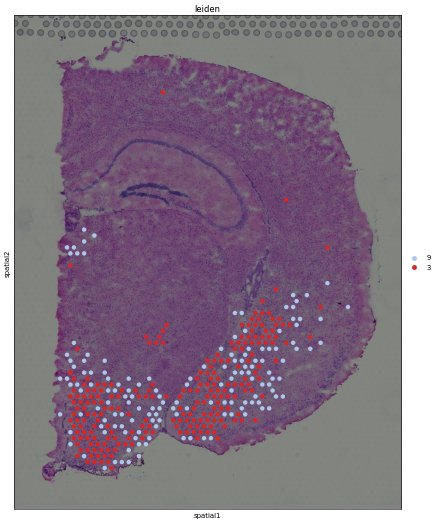

In [569]:
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest);

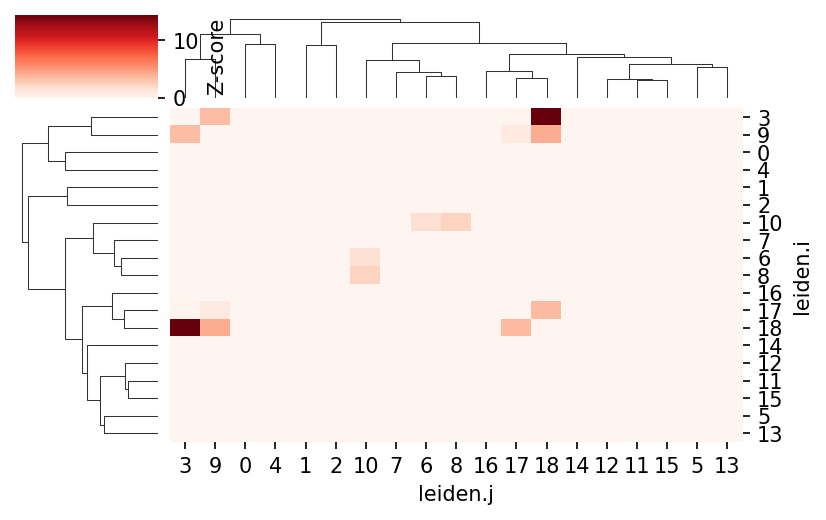

In [549]:
hm = nodes.pivot('leiden.i', 'leiden.j', 'z.score')
annot = nodes.pivot('leiden.i', 'leiden.j', 'n.obs')
g = sns.clustermap(hm.fillna(0),
                   cmap='Reds', vmin=0, vmax=vmax, cbar_kws={'label': 'Z-score'})
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.subplots_adjust(right=.5, bottom=.7)

load the data and calculate some basic metrics

## Calculation of Z-scores for different connectivity values and fixed n-permutations (this can take up to 20 min based on parameters and 1000 permutations each)

In [661]:
res = permutation_test_leiden_pairs_complex(adata, degree_start=1, degree_end=6, n_perm=100)

# degree 1
calculating connectivity graph with degree 1...
permutations...
# degree 2
calculating connectivity graph with degree 2...
permutations...
# degree 3
calculating connectivity graph with degree 3...
permutations...


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# degree 4
calculating connectivity graph with degree 4...
permutations...
# degree 5
calculating connectivity graph with degree 5...
permutations...


/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

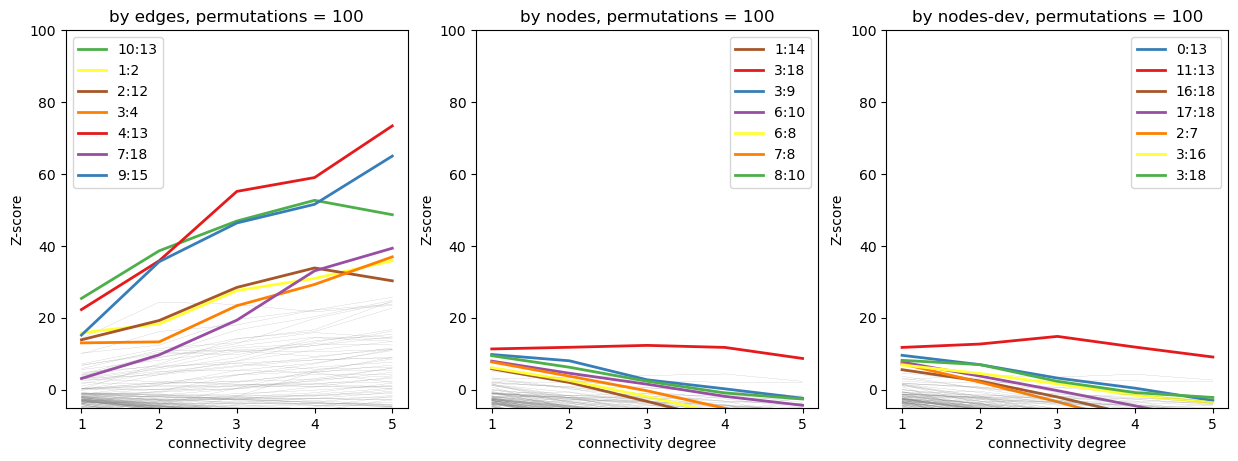

In [662]:
rcParams['figure.figsize'] = [15, 5]
rcParams['figure.dpi'] = 100

pi = 0

colors_top = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628"]
for mode, grp in res.groupby('mode'):
    plt.subplot(1, 3, pi + 1)
    max_by_k = grp.sort_values('z.score', ascending=False).drop_duplicates('k').set_index('k')['z.score'].to_dict()
    color_by_k = grp.sort_values('z.score', ascending=False).drop_duplicates('k').head(len(colors_top)).set_index('k')
    color_by_k['color'] = colors_top
    color_by_k = color_by_k['color'].to_dict()
    for k, grp2 in grp.groupby(['k']):
        n_perm = list(set(grp2['n.perm']))[0]
        # print(k, sel.shape)
        plt.plot(grp2['n.degree'], grp2['z.score'], c=color_by_k[k] if k in color_by_k else 'gray',
                label=k if k in color_by_k else '',
                lw=2.0 if k in color_by_k else .1);
        plt.xlabel('connectivity degree')
        plt.ylabel('Z-score');
        plt.title('by %s, permutations = %i' % (mode, n_perm))
        plt.legend();
    plt.ylim([-5, 100])
    pi += 1

In [654]:
# res[(res['mode'] == 'nodes-dev')].sort_values('z.score', ascending=False).head()

## One case from nodes-dev seems not ok

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'leiden.query' as categorical


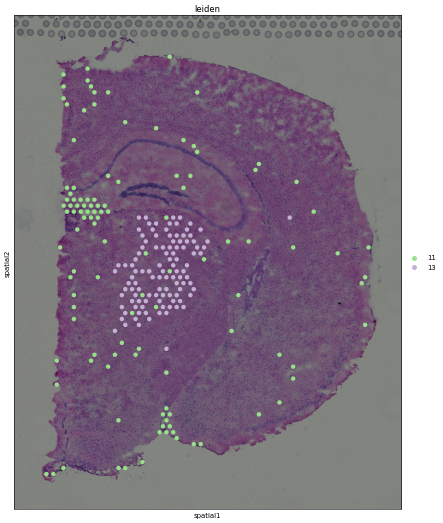

In [655]:
settest = {'11', '13'}
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest)

In [657]:
res[(res['mode'] == 'nodes')].sort_values('z.score', ascending=False).head()

,leiden.i,leiden.j,n.obs,mode,k,n.i,n.j,z.score,n.exp,sigma,n.degree,n.perm
128,18,3,129,nodes,3:18,21,220,13.655699,41.1,6.436873,2,10
128,18,3,169,nodes,3:18,21,220,12.702114,71.7,7.660142,3,10
59,9,3,237,nodes,3:9,147,220,9.570822,119.5,12.276898,1,10
59,9,3,330,nodes,3:9,147,220,9.175466,240.6,9.743374,2,10
128,18,3,77,nodes,3:18,21,220,8.594156,16.8,7.004760,1,10


## One case from mode=nodes seems ok

... storing 'leiden.query' as categorical


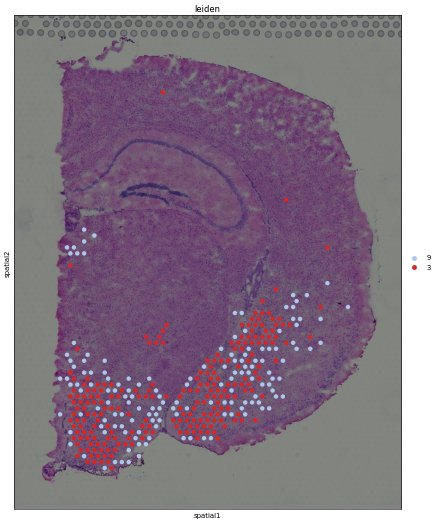

In [708]:
settest = {'3', '9'}
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest)

## One case from mode=edges seem not ok

... storing 'leiden.query' as categorical


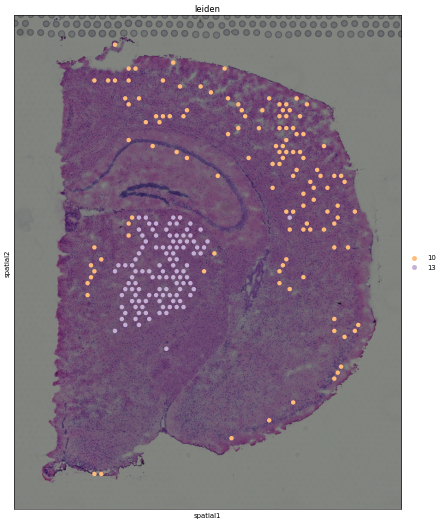

In [660]:
settest = {'10', '13'}
rcParams['figure.dpi'] = 50
rcParams['figure.figsize'] = [10, 15]
adata.obs['leiden.query'] = np.where(adata.obs['leiden'].isin(settest), adata.obs['leiden'], 'others');
sc.pl.spatial(adata, color ="leiden", groups=settest)